In [64]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv

In [65]:
DATA_FOLDER = 'deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

Train samples: 401
Test samples: 400


In [66]:
train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['mp4', 'json']


In [67]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

Files with extension `mp4`: 400
Files with extension `json`: 1


In [68]:
test_list = list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))
ext_dict = []
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

Extensions: ['mp4']
Files with extension `mp4`: 400


In [69]:
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


In [70]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [71]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing_data(meta_train_df)

,label,split,original
Total,0,0,77
Percent,0.0,0.0,19.25
Types,object,object,object


In [72]:
missing_data(meta_train_df.loc[meta_train_df.label=='REAL'])

,label,split,original
Total,0,0,77
Percent,0.0,0.0,100.0
Types,object,object,object


In [73]:
%%capture
%pip install /facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl

In [74]:
import os
import json
import time
import numpy as np
import torch
from PIL import Image
import cv2

import tensorflow as tf
from facenet_pytorch import MTCNN
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model

from sklearn.model_selection   import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import StandardScaler
from sklearn.svm               import SVC
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import VotingClassifier
from sklearn.metrics           import roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling        import SMOTE


# 3) Xception 기반 Feature Extractor 준비
base = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3))
# base.load_weights('/kaggle/input/imagenet/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
x = base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base.input, outputs=x)
for layer in base.layers:
    layer.trainable = False

# 4) facenet-pytorch MTCNN 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn  = MTCNN(keep_all=True, device=device, image_size=299)

# Optional: Albumentations 증강 정의
import albumentations as A
# augmentor = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.3),
#     A.GaussianBlur(p=0.2),
# ])

def create_train_transforms(size=299):
    return A.Compose([
        A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        A.GaussNoise(p=0.1),
        A.GaussianBlur(blur_limit=3, p=0.05),
        A.HorizontalFlip(),
        A.SmallestMaxSize(max_size=size),
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.OneOf([
            A.RandomBrightnessContrast(),
            A.FancyPCA(),
            A.HueSaturationValue()
        ], p=0.7),
        A.ToGray(p=0.2),
        # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, value = 0, 
        #                    border_mode=cv2.BORDER_CONSTANT, p=0.5)
    ])
augmentor = create_train_transforms(size=299)

def extract_face_features_facenet(video_path, 
                                  model=feature_extractor,
                                  frames_to_sample=16,
                                  augment=False,
                                  augmentor = augmentor):
    """
    1) 비디오에서 frames_to_sample만큼 프레임 샘플링
    2) facenet-pytorch MTCNN으로 얼굴 검출 → 크롭
    3) Xception 전처리 + batch predict → (N, feature_dim) 반환
    """
    cap    = cv2.VideoCapture(video_path)
    total  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs   = np.linspace(0, total-1, frames_to_sample, dtype=int)
    faces  = []
    
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        
        # BGR → RGB → PIL.Image
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(rgb)
        
        # MTCNN 검출
        boxes, probs = mtcnn.detect(img)
        if boxes is None:
            continue
        
        # 확률이 가장 높은 얼굴 1개 선택
        idx0 = int(np.argmax(probs))
        x1, y1, x2, y2 = boxes[idx0].astype(int)
        # 좌표 보정
        x1, y1 = max(0,x1), max(0,y1)
        face = rgb[y1:y2, x1:x2]
        # 리사이즈
        face = cv2.resize(face, (299,299))
        if augment and augmentor is not None:
            face = augmentor(image=face)['image']
        faces.append(face)
    
    cap.release()
    
    if len(faces)==0:
        # 검출 실패 시 0벡터 반환
        return np.zeros((frames_to_sample, model.output_shape[-1]))
    
    # batch predict
    batch = np.stack(faces, axis=0)            # (N,299,299,3)
    batch = preprocess_input(batch)            # Xception 전처리
    feats = model.predict(batch, verbose=0)    # (N, feature_dim)
    return feats

c:\Users\UserK\miniconda3\envs\project\lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict

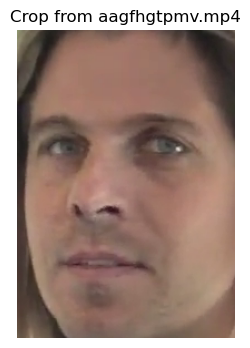

In [75]:
def get_one_mtcnn_crop(video_path, frame_idx=None):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # frame_idx를 지정하지 않으면 중간 프레임 하나를 고릅니다.
    if frame_idx is None:
        frame_idx = total // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise RuntimeError("프레임을 읽어올 수 없습니다.")
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(rgb)
    boxes, probs = mtcnn.detect(img)
    if boxes is None or len(boxes)==0:
        raise RuntimeError("얼굴이 검출되지 않았습니다.")
    
    # 신뢰도 가장 높은 얼굴 1개만 선택
    idx0 = int(np.argmax(probs))
    x1, y1, x2, y2 = boxes[idx0].astype(int)
    x1, y1 = max(0,x1), max(0,y1)
    crop = rgb[y1:y2, x1:x2]
    return crop

train_dir           = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)


# ─── 4) 테스트 및 시각화 ────────────────────────────────────
# 샘플 비디오 하나 고르기
video_files = [f for f in os.listdir(train_dir) if f.endswith('.mp4')]
sample_video = video_files[0]
sample_path  = os.path.join(train_dir, sample_video)

# 얼굴 크롭 받아오기
crop_img = get_one_mtcnn_crop(sample_path)

# 화면에 표시
plt.figure(figsize=(4,4))
plt.imshow(crop_img)
plt.axis('off')
plt.title(f"Crop from {sample_video}")
plt.show()

In [76]:
# 예시: train 디렉토리에서 첫 번째 비디오로 테스트
#  os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER
train_dir = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)
sample_video = os.listdir(train_dir)[0]   
sample_path = os.path.join(train_dir, sample_video)

# 16프레임씩 뽑아서 (16, feature_dim) 크기의 배열이 나오는지 확인
feats = extract_face_features_facenet(sample_path)
print("Features shape:", feats.shape)  
# → (16, 2048) 같은 형태로 나와야 합니다.


Features shape: (16, 2048)


In [77]:
import json

json_path = os.path.join(train_dir, 'metadata.json')
with open(json_path, 'r') as f:
    meta = json.load(f)

# 1) 구조 확인
print(type(meta))           # → dict
print(list(meta.keys())[:5])   # 첫 5개 키(파일명) 출력
print(list(meta.values())[:5]) # 해당 키의 value(라벨 등 정보) 예시 출력


<class 'dict'>
['aagfhgtpmv.mp4', 'aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4', 'abqwwspghj.mp4']
[{'label': 'FAKE', 'split': 'train', 'original': 'vudstovrck.mp4'}, {'label': 'FAKE', 'split': 'train', 'original': 'jdubbvfswz.mp4'}, {'label': 'REAL', 'split': 'train', 'original': None}, {'label': 'FAKE', 'split': 'train', 'original': 'atvmxvwyns.mp4'}, {'label': 'FAKE', 'split': 'train', 'original': 'qzimuostzz.mp4'}]


In [78]:
# 6) Build dataset
X_list, y_list = [], []
for vf, info in meta.items():
    path = os.path.join(train_dir, vf)
    feats = extract_face_features_facenet(path, frames_to_sample=16, augment=True, augmentor=augmentor)
    X_list.append(feats.mean(axis=0))
    y_list.append(1 if info['label']=='FAKE' else 0)
X = np.vstack(X_list)
y = np.array(y_list)
print(f"Dataset: X={X.shape}, y distribution={np.bincount(y)}")


Dataset: X=(400, 2048), y distribution=[ 77 323]


In [79]:
# 6) Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 8) Address class imbalance with SMOTE
t = time.time()
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(f"SMOTE applied: from {X_train.shape[0]} to {X_res.shape[0]} samples, elapsed {time.time()-t:.2f}s")


SMOTE applied: from 320 to 516 samples, elapsed 0.23s


In [80]:
import numpy as np
uniques, counts = np.unique(y_val, return_counts=True)
print(dict(zip(uniques, counts)))

{0: 15, 1: 65}


In [81]:
clf = SVC(kernel='rbf', C=1.0, probability=True,
          class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred  = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]

print(f"SVM Val Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"SVM Val   AUC: {roc_auc_score(y_val, y_proba):.4f}")
print(classification_report(y_val, y_pred, target_names=['REAL','FAKE']))

SVM Val Accuracy: 0.7750
SVM Val   AUC: 0.7590
              precision    recall  f1-score   support

        REAL       0.42      0.53      0.47        15
        FAKE       0.89      0.83      0.86        65

    accuracy                           0.78        80
   macro avg       0.65      0.68      0.66        80
weighted avg       0.80      0.78      0.78        80



In [82]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score, classification_report

import tensorflow_addons as tfa

# ── 1) MLP 모델 정의 & 학습 ────────────────────────────────
feat_dim = X_train.shape[1]

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(feat_dim,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

mlp.compile(    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(
        alpha=0.25,   # 소수 클래스(=REAL) 비율에 맞게 조정
        gamma=2.0     
    ),
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

class_weight = {
    0 : 2.0,
    1 : 1.0
}

mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    class_weight=class_weight,
    verbose=2
)

# MLP 확률 예측
y_proba_mlp = mlp.predict(X_val).ravel()

Epoch 1/100


c:\Users\UserK\miniconda3\envs\project\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\UserK\miniconda3\envs\project\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

20/20 - 1s - loss: 0.1975 - auc: 0.5706 - val_loss: 0.1471 - val_auc: 0.5421 - 591ms/epoch - 30ms/step
Epoch 2/100
20/20 - 0s - loss: 0.0941 - auc: 0.6467 - val_loss: 0.0621 - val_auc: 0.6641 - 71ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.0886 - auc: 0.6600 - val_loss: 0.0589 - val_auc: 0.6692 - 69ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.0752 - auc: 0.7515 - val_loss: 0.0602 - val_auc: 0.6646 - 71ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.0658 - auc: 0.8090 - val_loss: 0.0517 - val_auc: 0.7338 - 72ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.0625 - auc: 0.8251 - val_loss: 0.0502 - val_auc: 0.7518 - 73ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.0650 - auc: 0.8162 - val_loss: 0.0515 - val_auc: 0.7677 - 81ms/epoch - 4ms/step
Epoch 8/100
20/20 - 0s - loss: 0.0662 - auc: 0.8074 - val_loss: 0.0502 - val_auc: 0.7579 - 83ms/epoch - 4ms/step
Epoch 9/100
20/20 - 0s - loss: 0.0622 - auc: 0.8529 - val_loss: 0.0608 - val_auc: 0.7390 - 86ms/epoch - 4m

In [83]:
from sklearn.metrics import classification_report

# 1) MLP 확률 → 이진 예측
y_pred_mlp = (y_proba_mlp >= 0.5).astype(int)

# 2) 리포트 출력
print("MLP Classification Report")
print(classification_report(
    y_val,
    y_pred_mlp,
    target_names=['REAL','FAKE']
))

MLP Classification Report
              precision    recall  f1-score   support

        REAL       0.92      0.73      0.81        15
        FAKE       0.94      0.98      0.96        65

    accuracy                           0.94        80
   macro avg       0.93      0.86      0.89        80
weighted avg       0.94      0.94      0.93        80



In [ ]:
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
import joblib
from tensorflow.keras.models import load_model
import pandas as pd

# ── MLP 예측 ──────────────────────────────────────────────────────────────
y_proba_mlp = mlp.predict(X_val).ravel()
y_pred_mlp  = (y_proba_mlp >= 0.5).astype(int)

# ── 3) 수동 Hard Voting ─────────────────────────────────────────────────────
# • 한쪽이라도 FAKE(1)이면 FAKE
ens_pred    = ((y_pred + y_pred_mlp) >= 1).astype(int)
# • 양쪽 모두 FAKE일 때만 FAKE
strict_pred = ((y_pred + y_pred_mlp) == 2).astype(int)

# ── 4) 하드 보팅 분류 리포트 ─────────────────────────────────────────────────
print("Manual Hard Voting Classification Report (>=1)")
print(classification_report(y_val, ens_pred, target_names=['REAL','FAKE']))

print("Manual Hard Voting Classification Report (==2)")
print(classification_report(y_val, strict_pred, target_names=['REAL','FAKE']))

# ── 5) AUC 계산 (확률 평균) ─────────────────────────────────────────────────
ens_proba = (y_proba + y_proba_mlp) / 2.0
print("Manual Hard Voting AUC:", roc_auc_score(y_val, ens_proba))

# ── 6) 개별 모델 저장 ───────────────────────────────────────────────────────
joblib.dump(clf, 'svm_model.pkl')         # SVM 저장
mlp.save('mlp_model.h5')                  # MLP 저장
print("Saved: 'svm_model.pkl', 'mlp_model.h5'")

# ── 7) 하드 보팅 앙상블 객체 저장 ─────────────────────────────────────────────
ensemble_dict = {'svm': clf, 'mlp': mlp}
joblib.dump(ensemble_dict, 'hard_voting_ensemble.pkl')
print("Saved ensemble: 'hard_voting_ensemble.pkl'")

# ── 8) Kaggle 제출용 CSV 저장 ───────────────────────────────────────────────
# test_filenames: 테스트셋의 파일명 리스트 (예: ['abc.mp4', 'def.mp4', ...])
# X_test: 테스트셋의 특성
TEST_FOLDER = "deepfake-detection-challenge/test_videos"
test_filenames = [f for f in os.listdir(TEST_FOLDER) if f.endswith(".mp4")]
test_paths = [os.path.join(TEST_FOLDER, fname) for fname in test_filenames]

# 제출용 테스트 데이터 생성
X_test_list = []
for path in test_paths:
    feats = extract_face_features_facenet(path, frames_to_sample=16)
    X_test_list.append(feats.mean(axis=0))
X_test = np.vstack(X_test_list)


# SVM 및 MLP 예측 확률 생성 (테스트셋)
proba_svm_test = clf.predict_proba(X_test)[:, 1]
proba_mlp_test = mlp.predict(X_test).ravel()

# 하드 보팅 방식 (≥1개가 FAKE로 분류 시 FAKE)
pred_svm_test = (proba_svm_test >= 0.5).astype(int)
pred_mlp_test = (proba_mlp_test >= 0.5).astype(int)
final_pred_test = ((pred_svm_test + pred_mlp_test) >= 1).astype(int)

# Soft Voting 확률 (평균값)
final_proba_test = (proba_svm_test + proba_mlp_test) / 2.0



3/3 [==============================] - 0s 1ms/step
Manual Hard Voting Classification Report (>=1)
              precision    recall  f1-score   support

        REAL       0.89      0.53      0.67        15
        FAKE       0.90      0.98      0.94        65

    accuracy                           0.90        80
   macro avg       0.90      0.76      0.80        80
weighted avg       0.90      0.90      0.89        80

Manual Hard Voting Classification Report (==2)
              precision    recall  f1-score   support

        REAL       0.50      0.73      0.59        15
        FAKE       0.93      0.83      0.88        65

    accuracy                           0.81        80
   macro avg       0.72      0.78      0.74        80
weighted avg       0.85      0.81      0.82        80

Manual Hard Voting AUC: 0.8882051282051283
Saved: 'svm_model.pkl', 'mlp_model.h5'
INFO:tensorflow:Assets written to: ram://4603f95d-db4b-42e2-97df-2088cbd10482/assets
Saved ensemble: 'hard_voting_ensem

In [105]:
def get_one_mtcnn_crop_retry(video_path, frame_idx=None, max_trials=5):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # 기본 인덱스 리스트: 중간 프레임 ± trial 간격
    if frame_idx is None:
        base = total // 2
        idxs = [min(max(0, base + i*(total//20)), total-1) for i in range(-max_trials//2, max_trials//2+1)]
    else:
        idxs = [frame_idx]
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret: continue
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(rgb)
        boxes, probs = mtcnn.detect(img)
        if boxes is not None and len(boxes)>0:
            i0 = int(np.argmax(probs))
            x1,y1,x2,y2 = boxes[i0].astype(int)
            cap.release()
            return rgb[y1:y2, x1:x2]
    cap.release()
    raise RuntimeError("얼굴 검출 실패 (모든 trial)")

# 이후 get_one_mtcnn_crop → get_one_mtcnn_crop_retry 로 교체


1/1 [==============================] - 0s 12ms/step


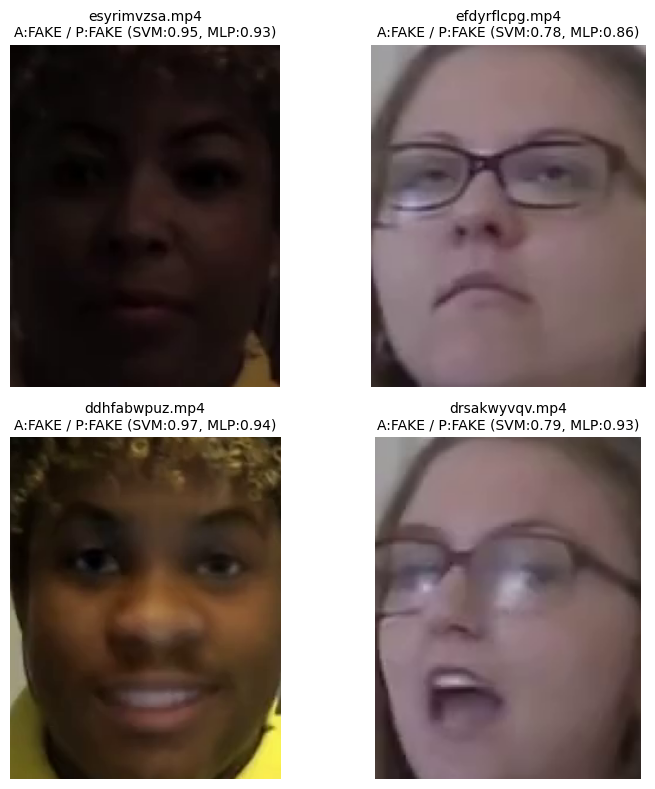

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.models import load_model
import cv2
import joblib

# ── 모델 로드 ─────────────────────────────────────────────────────────────

mlp = load_model('mlp_model.h5')
clf = joblib.load('svm_model.pkl')

# # ── 0) LSTM 모델 로드 ─────────────────────────────────────────────
# lstm_model = load_model('lstm_model.h5')
# # LSTM이 기대하는 시퀀스 길이
# seq_len = lstm_model.input_shape[1]

# ── Feature 추출 (단일 벡터 요약용) ─────────────────────────────────────
def extract_video_feature_for_mlp_svm(video_path, frames_to_sample=16):
    feats = extract_face_features_facenet(video_path, frames_to_sample=frames_to_sample)
    return feats.mean(axis=0)  # (feat_dim,)


# ── 시각화용 샘플 추출 및 예측 ───────────────────────────────────────────
def visualize_voting_predictions(train_dir, meta, n_rows=2, n_cols=2):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    N = n_rows * n_cols

    video_files = [f for f in os.listdir(train_dir) if f.endswith('.mp4')]
    random.shuffle(video_files)
    sample_list = []

    for vf in video_files:
        path = os.path.join(train_dir, vf)
        try:
            _ = get_one_mtcnn_crop(path, frame_idx=0)
            sample_list.append(vf)
        except RuntimeError:
            continue
        if len(sample_list) >= N:
            break

    for idx, vf in enumerate(sample_list):
        ax = axes[idx // n_cols, idx % n_cols]
        path = os.path.join(train_dir, vf)
        actual = meta[vf]['label']
        crop = get_one_mtcnn_crop(path, frame_idx=0)

        # feature 추출 및 hard voting 예측
        X_feat = extract_video_feature_for_mlp_svm(path).reshape(1, -1)
        proba_mlp = mlp.predict(X_feat).ravel()[0]
        proba_svm = clf.predict_proba(X_feat)[:, 1][0]
        pred_mlp = int(proba_mlp >= 0.5)
        pred_svm = int(proba_svm >= 0.5)
        # final_pred = int(pred_mlp + pred_svm >= 1)  # hard voting (≥1)
        final_pred = int(proba_mlp >= 0.5)
        final_label = 'FAKE' if final_pred == 1 else 'REAL'

        ax.imshow(crop)
        ax.axis('off')
        ax.set_title(f"{vf}\nA:{actual} / P:{final_label} (SVM:{proba_svm:.2f}, MLP:{proba_mlp:.2f})", fontsize=10)

    plt.tight_layout()
    plt.show()

# ── 데이터셋 경로 및 메타 정보 설정 ─────────────────────────────
DATA_FOLDER = 'deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
train_dir = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)

# 메타 정보 로드
import json
meta_path = os.path.join(train_dir, 'metadata.json')
with open(meta_path, 'r') as f:
    meta = json.load(f)

# ── 예측 시각화 실행 ───────────────────────────────────────────
visualize_voting_predictions(train_dir, meta, n_rows=2, n_cols=2)



# Detection


In [ ]:
import os
import random
import numpy as np
import json
import cv2
import joblib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input
import shutil


# ── Settings ─────────────────────────────────────────────────
DATA_FOLDER         = 'deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
train_dir           = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)
SEG_INPUT_DIR       = 'segmentation_input'
BBOX_OUTPUT_JSON    = 'bboxes.json'
os.makedirs(SEG_INPUT_DIR, exist_ok=True)

# ── 모델 로드 ─────────────────────────────────────────────────
clf = joblib.load('svm_model.pkl')
mlp = load_model('mlp_model.h5')

# ── Feature Extractor & MTCNN assumed to be available ───────
# mtcnn, feature_extractor 등이 글로벌하게 선언돼 있어야 함

def extract_video_feature_for_mlp_svm(video_path, frames_to_sample=16):
    feats = extract_face_features_facenet(video_path, frames_to_sample=frames_to_sample)
    return feats.mean(axis=0)

def classify_video_hard_vote(video_path):
    X_feat = extract_video_feature_for_mlp_svm(video_path).reshape(1, -1)
    proba_mlp = mlp.predict(X_feat).ravel()[0]
    proba_svm = clf.predict_proba(X_feat)[:, 1][0]
    pred_mlp = int(proba_mlp >= 0.5)
    pred_svm = int(proba_svm >= 0.5)
    # final_pred = int(pred_mlp + pred_svm >= 1)
    final_pred = int(proba_mlp >= 0.5)
    pred = 'FAKE' if final_pred == 1 else 'REAL'
    return pred, proba_svm, proba_mlp

# ── YOLOv8 객체 ───────────────────────────────────────────────
yolo = YOLO('yolov8n.pt')

def run_yolo_detection(video_path, conf=0.6):
    results = yolo.predict(source=video_path, conf=conf, stream=True, verbose=False)
    r = next(results)
    boxes  = r.boxes.xyxy.cpu().numpy()
    scores = r.boxes.conf.cpu().numpy()
    classes = r.boxes.cls.cpu().numpy()

    # 사람(class 0)만 필터링
    person_boxes = []
    person_scores = []
    for box, score, cls in zip(boxes, scores, classes):
        if int(cls) == 0:
            person_boxes.append(box)
            person_scores.append(score)

    return np.array(person_boxes), np.array(person_scores)

# ── 1) Filter FAKE videos ────────────────────────────────────
video_files = [f for f in os.listdir(train_dir) if f.endswith('.mp4')]
fake_videos = []
for vf in video_files:
    path = os.path.join(train_dir, vf)
    pred, prob_svm, prob_mlp = classify_video_hard_vote(path)
    if pred == 'FAKE':
        fake_videos.append((vf, prob_svm, prob_mlp))

# ── 2) Extract YOLO boxes and save for segmentation ─────────
bbox_annotation = {}

for vf, prob_svm, prob_mlp in fake_videos:
    video_path = os.path.join(train_dir, vf)
    basename = os.path.splitext(vf)[0]

    boxes, scores = run_yolo_detection(video_path)
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idx = total // 2 if total > 0 else 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        continue

    # out_img_path = os.path.join(SEG_INPUT_DIR, f"{basename}.jpg")
    # cv2.imwrite(out_img_path, frame)

    out_vid_path = os.path.join(SEG_INPUT_DIR, f"{basename}.mp4")
    shutil.copy(video_path, out_vid_path)


    h_img, w_img, _ = frame.shape
    valid_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(0, min(x1, w_img - 1)), max(0, min(y1, h_img - 1))
        x2, y2 = max(0, min(x2, w_img - 1)), max(0, min(y2, h_img - 1))
        valid_boxes.append([x1, y1, x2, y2])

    bbox_annotation[f"{basename}.jpg"] = valid_boxes

# ── 3) Save YOLO boxes to JSON ───────────────────────────────
with open(BBOX_OUTPUT_JSON, 'w') as f:
    json.dump(bbox_annotation, f, indent=2)

print("✅ Hard Voting 기반으로 FAKE 분류된 영상에 대해 사람만 YOLO 박스로 추출 완료")


1/1 [==============================] - 0s 21ms/step
✅ Hard Voting 기반으로 FAKE 분류된 영상에 대해 사람만 YOLO 박스로 추출 완료


1/1 [==============================] - 0s 34ms/step


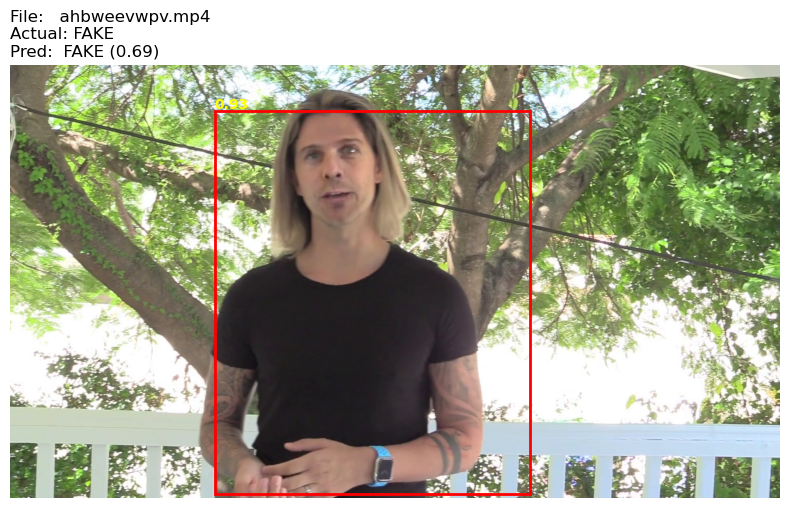

In [145]:
import os
import random
import numpy as np
import json
import cv2
import joblib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input

# ── Settings ─────────────────────────────────────────────────
DATA_FOLDER         = 'deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
train_dir           = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)

# ── 모델 로드 ─────────────────────────────────────────────────
clf = joblib.load('svm_model.pkl')
mlp = load_model('mlp_model.h5')

# ── Feature Extractor & MTCNN assumed to be available ───────
# mtcnn, feature_extractor 등이 글로벌하게 선언돼 있어야 함

def extract_video_feature_for_mlp_svm(video_path, frames_to_sample=16):
    feats = extract_face_features_facenet(video_path, frames_to_sample=frames_to_sample)
    return feats.mean(axis=0)

def classify_video_hard_vote(video_path):
    X_feat = extract_video_feature_for_mlp_svm(video_path).reshape(1, -1)
    proba_mlp = mlp.predict(X_feat).ravel()[0]
    proba_svm = clf.predict_proba(X_feat)[:, 1][0]
    pred_mlp = int(proba_mlp >= 0.5)
    pred_svm = int(proba_svm >= 0.5)
    final_pred = int(pred_mlp + pred_svm >= 1)
    pred = 'FAKE' if final_pred == 1 else 'REAL'
    return pred, float((proba_mlp + proba_svm) / 2)

# ── YOLOv8 객체 ───────────────────────────────────────────────
yolo = YOLO('yolov8n.pt')

def run_yolo_detection(video_path, conf=0.6):
    results = yolo.predict(source=video_path, conf=conf, stream=True, verbose=False)
    r = next(results)
    boxes  = r.boxes.xyxy.cpu().numpy()
    scores = r.boxes.conf.cpu().numpy()
    return boxes, scores

# ── 1) 랜덤 샘플 예측 및 시각화 ───────────────────────────────
video_files = [f for f in os.listdir(train_dir) if f.endswith('.mp4')]
# sample_vf   = random.choice(video_files)
sample_vf = 'ahbweevwpv.mp4'
sample_path = os.path.join(train_dir, sample_vf)

# 실제 라벨 (메타가 있다면)
meta_path = os.path.join(train_dir, 'metadata.json')
if os.path.exists(meta_path):
    with open(meta_path) as f:
        meta = json.load(f)
    actual_label = meta[sample_vf]['label']
else:
    actual_label = '(unknown)'

# 예측 수행
pred, prob = classify_video_hard_vote(sample_path)

# 중간 프레임 캡처
cap   = cv2.VideoCapture(sample_path)
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
mid   = total // 2
cap.set(cv2.CAP_PROP_POS_FRAMES, mid)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("프레임 로드 실패")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# YOLO Detection
boxes, scores = run_yolo_detection(sample_path, conf=0.6)

# 시각화
plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.axis('off')

for (x1, y1, x2, y2), s in zip(boxes, scores):
    w, h = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(x1, y1 - 5, f"{s:.2f}", color='yellow', fontsize=10, weight='bold')

plt.title(
    f"File:   {sample_vf}\n"
    f"Actual: {actual_label}\n"
    f"Pred:  {pred} ({prob:.2f}) ",
    loc='left', fontsize=12
)
plt.tight_layout()
plt.show()


# Segmentation


In [141]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
from facenet_pytorch import MTCNN

# ── Settings ─────────────────────────────────────────────────
SEG_INPUT_DIR       = 'segmentation_input'
BBOX_JSON_PATH      = 'bboxes.json'
SEG_OUTPUT_DIR      = 'segmentation_output_video'
os.makedirs(SEG_OUTPUT_DIR, exist_ok=True)

# ── Load bbox annotation ─────────────────────────────────────
with open(BBOX_JSON_PATH, 'r') as f:
    bbox_data = json.load(f)

# ── MTCNN 얼굴 검출기 로드 ───────────────────────────────────
mtcnn = MTCNN(keep_all=True, device='cuda' if cv2.cuda.getCudaEnabledDeviceCount() > 0 else 'cpu')

# ── 얼굴 영역 분할 마스크 생성 함수 ───────────────────────────
def segment_face_with_mtcnn(frame, ref_boxes=None):
    mask = np.zeros_like(frame)
    detected = False

    if ref_boxes:
        for ref in ref_boxes:
            x1, y1, x2, y2 = map(int, ref)
            cropped = frame[y1:y2, x1:x2]
            sub_boxes, _ = mtcnn.detect(cropped)
            if sub_boxes is not None:
                detected = True
                for sb in sub_boxes:
                    dx1, dy1, dx2, dy2 = map(int, sb)
                    fx1, fy1 = x1 + dx1, y1 + dy1
                    fx2, fy2 = x1 + dx2, y1 + dy2
                    fx1, fy1 = max(fx1, 0), max(fy1, 0)
                    fx2, fy2 = min(fx2, frame.shape[1]), min(fy2, frame.shape[0])
                    face = frame[fy1:fy2, fx1:fx2].copy()
                    tint = np.zeros_like(face)
                    tint[:, :, 1] = 180
                    blended = cv2.addWeighted(face, 0.5, tint, 0.5, 0)
                    mask[fy1:fy2, fx1:fx2] = blended

    if not detected:
        boxes, _ = mtcnn.detect(frame)
        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = map(int, box)
                x1, y1 = max(x1, 0), max(y1, 0)
                x2, y2 = min(x2, frame.shape[1]), min(y2, frame.shape[0])
                face = frame[y1:y2, x1:x2].copy()
                tint = np.zeros_like(face)
                tint[:, :, 1] = 180
                blended = cv2.addWeighted(face, 0.5, tint, 0.5, 0)
                mask[y1:y2, x1:x2] = blended

    combined = np.where(mask.sum(axis=-1, keepdims=True) > 0, mask, frame)
    return combined

# ── Process videos ───────────────────────────────────────────
video_files = [f for f in os.listdir(SEG_INPUT_DIR) if f.endswith('.mp4')]

for vf in tqdm(video_files, desc="Segmenting faces"):
    video_path = os.path.join(SEG_INPUT_DIR, vf)
    cap = cv2.VideoCapture(video_path)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)

    out_path = os.path.join(SEG_OUTPUT_DIR, vf)
    writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    basename = os.path.splitext(vf)[0] + '.jpg'
    ref_boxes = bbox_data.get(basename, None)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        segmented_frame = segment_face_with_mtcnn(frame, ref_boxes=ref_boxes)
        writer.write(segmented_frame)

    cap.release()
    writer.release()

print("✅ 영상 기반 얼굴 추적 및 분할 완료")


Segmenting faces: 100%|██████████| 309/309 [3:25:04<00:00, 39.82s/it]  

✅ 영상 기반 얼굴 추적 및 분할 완료


Segmenting faces (Haar):   3%|▎         | 8/309 [13:13<8:17:32, 99.18s/it]  


KeyboardInterrupt: 